In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv

In [2]:
data_dir = "/kaggle/input/new-generated-and-collected-printed-t-shirts"
image_dir = "/kaggle/input/new-generated-and-collected-printed-t-shirts/tshirt"
image_root = "//kaggle/input/new-generated-and-collected-printed-t-shirts"

Sample of T-Shirts


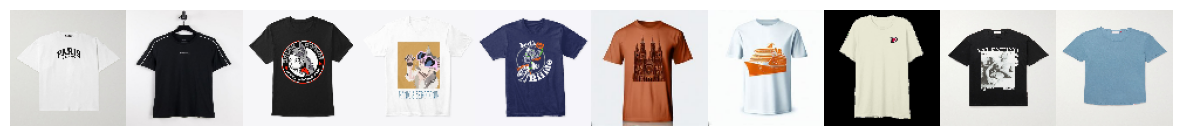

In [3]:
no_plots = 10*1
images = glob(f'{image_dir}/*')

plt.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample of T-Shirts")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    sample_img = cv.resize(sample_img,(100,100))
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB))
plt.show()

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms


# helper display function
def tensor_imshow(img,dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
def get_dataloader(batch_size,image_size,data_dir=image_dir,num_workers=3):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        # We tranform our image values to be between -1 and 1 (the range of the tanh activation)
        transforms.Normalize(*stats), # 
    ])
    
    dataset = datasets.ImageFolder(root=data_dir,transform=transform)
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    return data_loader

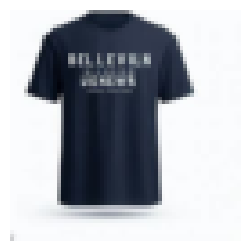

In [6]:
# Testing the dataloader
batch_size, image_size = 8, 64
train_loader = get_dataloader(batch_size,image_size,image_root)
dataiter = iter(train_loader)

img,_ = next(dataiter)
sample_img = img[-1]
tensor_imshow(sample_img)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Generator(nn.Module):
    def __init__(self,z_dim=10,in_chan=3,hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim
        
        self.generator = nn.Sequential(
            self.make_gen_block(z_dim,512,stride=1,padding=0),
            self.make_gen_block(512,256),
            self.make_gen_block(256,128),
            self.make_gen_block(128,64),
            self.make_gen_block(64,32),
            self.make_gen_block(32, in_chan,final_layer=True),
        )
    
    def make_gen_block(self,in_channels,op_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels,op_channels,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_channels))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator(x)

    def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)

In [9]:
#Testing Genarator
noise = Generator.get_noise(n_samples=5,z_dim=10)
g = Generator(z_dim=10,in_chan=3,hidden_dim=64)
# print(g)
img = g(noise)
print(img.shape)
assert img.shape == (5,3,128,128), "Generator Output Images shape incorrect"
print("Generator Test passed!!")

torch.Size([5, 3, 128, 128])
Generator Test passed!!


In [10]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=3,conv_dim=64,image_size=64):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(
            self.make_disc_block(3,32),
            self.make_disc_block(32,64),
            self.make_disc_block(64,128),
            self.make_disc_block(128,256),
            self.make_disc_block(256,512),
            self.make_disc_block(512,1,padding=0,final_layer=True),
        )
        
        
    def make_disc_block(self,in_chan,op_chan,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.Conv2d(in_chan,op_chan,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2*len(self.disc_cnn))*2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [11]:
#Testing Discriminator
d = Discriminator(im_chan=3,conv_dim=128,image_size=64)
# print(d)
img = torch.rand(4,3,128,128)
d_op = d(img)
assert d_op.shape == (4,1),"Discrimenator Output Images shape incorrect"
print("Discrimenator test passed!!")

Discrimenator test passed!!


In [12]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
def real_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size,device=device)*0.9 # real labels = 1 and lable smoothing => 0.9
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,device=device) # fake labels = 0
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [14]:
def print_tensor_images(images_tensor,save_pic = False,name = "my_image.jpg", k=1):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        if idx == k-1:
            break
    if save_pic:
        plt.savefig(name)
        
    else:
        plt.show()

def train(D, G, n_epochs,dataloader,d_optimizer,g_optimizer,z_dim,print_every=50,device='cpu'):
    
    ## Get some fixed data for sampling.##      
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)
    
    for epoch in range(1,n_epochs+1):
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            ### Discriminator part ###
            d_optimizer.zero_grad()
            
            #loss on real image
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,device=device)
            
            #loss on fake image
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,device=device)
            
            #total loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            ### Generator part ###
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out,device=device)
            g_loss.backward()
            g_optimizer.step()
        
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_loss.item(), g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

In [15]:
import torch.optim as optim

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ",device)

z_dim = 150
sample_size=8
beta_1 = 0.5
beta_2 = 0.999 

n_epochs = 500
lr = 0.0002

batch_size = 128
image_size = 128

Device is  cuda


In [17]:
gen = Generator(z_dim,in_chan=3,hidden_dim=64).to(device)
disc = Discriminator(im_chan=3,conv_dim=64,image_size=image_size).to(device)

g_optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
d_optimizer = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

dataloader = get_dataloader(batch_size,image_size,image_root)

Epoch [    1/  500] | d_loss: 0.4266 | g_loss: 5.5371
Epoch [    2/  500] | d_loss: 0.4738 | g_loss: 5.6858
Epoch [    3/  500] | d_loss: 0.3584 | g_loss: 6.7083
Epoch [    4/  500] | d_loss: 0.3473 | g_loss: 6.4445
Epoch [    5/  500] | d_loss: 0.5631 | g_loss: 10.1476
Epoch [    6/  500] | d_loss: 0.3440 | g_loss: 6.3574
Epoch [    7/  500] | d_loss: 0.3498 | g_loss: 8.8786
Epoch [    8/  500] | d_loss: 0.3323 | g_loss: 6.4647
Epoch [    9/  500] | d_loss: 0.3342 | g_loss: 7.3299
Epoch [   10/  500] | d_loss: 0.3567 | g_loss: 8.3729


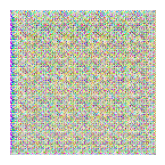

Epoch [   11/  500] | d_loss: 0.3344 | g_loss: 6.0226
Epoch [   12/  500] | d_loss: 0.3293 | g_loss: 6.3584
Epoch [   13/  500] | d_loss: 0.3313 | g_loss: 6.2171
Epoch [   14/  500] | d_loss: 0.4657 | g_loss: 3.5950
Epoch [   15/  500] | d_loss: 0.3992 | g_loss: 4.3346
Epoch [   16/  500] | d_loss: 0.3987 | g_loss: 4.0372
Epoch [   17/  500] | d_loss: 0.4079 | g_loss: 3.9869
Epoch [   18/  500] | d_loss: 0.7293 | g_loss: 4.6851
Epoch [   19/  500] | d_loss: 1.9764 | g_loss: 2.8858
Epoch [   20/  500] | d_loss: 0.4749 | g_loss: 3.4485


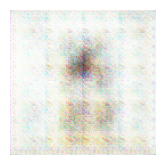

Epoch [   21/  500] | d_loss: 0.4440 | g_loss: 2.8192
Epoch [   22/  500] | d_loss: 0.5339 | g_loss: 1.2906
Epoch [   23/  500] | d_loss: 0.5391 | g_loss: 2.9197
Epoch [   24/  500] | d_loss: 0.6950 | g_loss: 1.7002
Epoch [   25/  500] | d_loss: 0.6427 | g_loss: 2.8379
Epoch [   26/  500] | d_loss: 0.5483 | g_loss: 2.7119
Epoch [   27/  500] | d_loss: 0.5354 | g_loss: 3.1386
Epoch [   28/  500] | d_loss: 0.5386 | g_loss: 2.0552
Epoch [   29/  500] | d_loss: 0.6266 | g_loss: 3.3267
Epoch [   30/  500] | d_loss: 0.5841 | g_loss: 2.0199


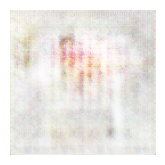

Epoch [   31/  500] | d_loss: 0.5816 | g_loss: 2.3491
Epoch [   32/  500] | d_loss: 0.8148 | g_loss: 2.0218
Epoch [   33/  500] | d_loss: 0.6953 | g_loss: 2.6399
Epoch [   34/  500] | d_loss: 0.4756 | g_loss: 3.8878
Epoch [   35/  500] | d_loss: 0.7440 | g_loss: 1.2266
Epoch [   36/  500] | d_loss: 0.4887 | g_loss: 2.5772
Epoch [   37/  500] | d_loss: 1.2260 | g_loss: 2.0389
Epoch [   38/  500] | d_loss: 0.5412 | g_loss: 2.9222
Epoch [   39/  500] | d_loss: 0.6280 | g_loss: 2.8572
Epoch [   40/  500] | d_loss: 0.7149 | g_loss: 1.3309


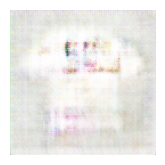

Epoch [   41/  500] | d_loss: 0.4708 | g_loss: 2.2346
Epoch [   42/  500] | d_loss: 0.5840 | g_loss: 3.0986
Epoch [   43/  500] | d_loss: 1.2746 | g_loss: 4.1749
Epoch [   44/  500] | d_loss: 0.9016 | g_loss: 4.4389
Epoch [   45/  500] | d_loss: 0.7106 | g_loss: 2.8891
Epoch [   46/  500] | d_loss: 0.7462 | g_loss: 4.1173
Epoch [   47/  500] | d_loss: 0.5676 | g_loss: 2.7408
Epoch [   48/  500] | d_loss: 0.4472 | g_loss: 2.7523
Epoch [   49/  500] | d_loss: 0.5361 | g_loss: 2.4694
Epoch [   50/  500] | d_loss: 0.6269 | g_loss: 2.4997


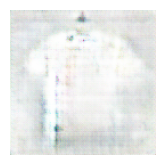

Epoch [   51/  500] | d_loss: 0.7843 | g_loss: 1.8598
Epoch [   52/  500] | d_loss: 1.0443 | g_loss: 2.0404
Epoch [   53/  500] | d_loss: 0.4519 | g_loss: 3.7011
Epoch [   54/  500] | d_loss: 0.7022 | g_loss: 2.4158
Epoch [   55/  500] | d_loss: 1.3616 | g_loss: 5.3365
Epoch [   56/  500] | d_loss: 0.5485 | g_loss: 2.5143
Epoch [   57/  500] | d_loss: 0.6372 | g_loss: 1.9545
Epoch [   58/  500] | d_loss: 0.6825 | g_loss: 3.3974
Epoch [   59/  500] | d_loss: 0.6306 | g_loss: 1.7885
Epoch [   60/  500] | d_loss: 0.6133 | g_loss: 4.3001


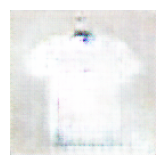

Epoch [   61/  500] | d_loss: 0.7220 | g_loss: 2.1930
Epoch [   62/  500] | d_loss: 0.5077 | g_loss: 2.7164
Epoch [   63/  500] | d_loss: 0.5606 | g_loss: 2.0279
Epoch [   64/  500] | d_loss: 1.8207 | g_loss: 5.3149
Epoch [   65/  500] | d_loss: 0.5651 | g_loss: 3.5030
Epoch [   66/  500] | d_loss: 0.8436 | g_loss: 1.7550
Epoch [   67/  500] | d_loss: 0.4387 | g_loss: 3.0868
Epoch [   68/  500] | d_loss: 0.4698 | g_loss: 2.7527
Epoch [   69/  500] | d_loss: 0.4476 | g_loss: 2.9568
Epoch [   70/  500] | d_loss: 0.7097 | g_loss: 2.0443


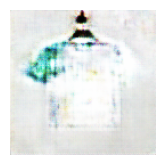

Epoch [   71/  500] | d_loss: 0.5977 | g_loss: 2.5429
Epoch [   72/  500] | d_loss: 0.5255 | g_loss: 3.1912
Epoch [   73/  500] | d_loss: 1.0589 | g_loss: 4.4431
Epoch [   74/  500] | d_loss: 0.5073 | g_loss: 2.7125
Epoch [   75/  500] | d_loss: 0.4845 | g_loss: 2.7098
Epoch [   76/  500] | d_loss: 0.5520 | g_loss: 3.3633
Epoch [   77/  500] | d_loss: 0.5828 | g_loss: 4.4719
Epoch [   78/  500] | d_loss: 0.6080 | g_loss: 1.9780
Epoch [   79/  500] | d_loss: 1.1600 | g_loss: 5.0765
Epoch [   80/  500] | d_loss: 1.1252 | g_loss: 5.3623


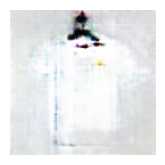

Epoch [   81/  500] | d_loss: 0.4741 | g_loss: 3.0305
Epoch [   82/  500] | d_loss: 0.4548 | g_loss: 2.3140
Epoch [   83/  500] | d_loss: 0.4896 | g_loss: 3.4604
Epoch [   84/  500] | d_loss: 0.4343 | g_loss: 3.4893
Epoch [   85/  500] | d_loss: 1.6202 | g_loss: 1.0937
Epoch [   86/  500] | d_loss: 0.5448 | g_loss: 2.7332
Epoch [   87/  500] | d_loss: 0.5031 | g_loss: 2.6637
Epoch [   88/  500] | d_loss: 0.6046 | g_loss: 2.0037
Epoch [   89/  500] | d_loss: 0.4741 | g_loss: 3.3517
Epoch [   90/  500] | d_loss: 0.6563 | g_loss: 1.9928


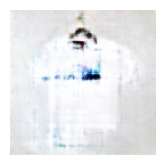

Epoch [   91/  500] | d_loss: 0.4656 | g_loss: 2.2151
Epoch [   92/  500] | d_loss: 0.7850 | g_loss: 4.1373
Epoch [   93/  500] | d_loss: 0.5044 | g_loss: 3.3305
Epoch [   94/  500] | d_loss: 0.6090 | g_loss: 4.1294
Epoch [   95/  500] | d_loss: 0.5731 | g_loss: 2.0959
Epoch [   96/  500] | d_loss: 0.4794 | g_loss: 2.6262
Epoch [   97/  500] | d_loss: 0.5195 | g_loss: 3.1085
Epoch [   98/  500] | d_loss: 0.6207 | g_loss: 1.4365
Epoch [   99/  500] | d_loss: 0.6088 | g_loss: 1.8242
Epoch [  100/  500] | d_loss: 0.4728 | g_loss: 3.4111


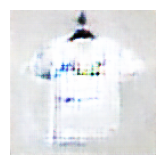

Epoch [  101/  500] | d_loss: 1.2746 | g_loss: 4.6333
Epoch [  102/  500] | d_loss: 0.5068 | g_loss: 3.3958
Epoch [  103/  500] | d_loss: 1.5291 | g_loss: 0.7108
Epoch [  104/  500] | d_loss: 0.8089 | g_loss: 3.7998
Epoch [  105/  500] | d_loss: 0.5582 | g_loss: 3.4018
Epoch [  106/  500] | d_loss: 0.9366 | g_loss: 4.1179
Epoch [  107/  500] | d_loss: 0.8135 | g_loss: 3.4524
Epoch [  108/  500] | d_loss: 0.5860 | g_loss: 1.9324
Epoch [  109/  500] | d_loss: 0.4259 | g_loss: 3.2172
Epoch [  110/  500] | d_loss: 0.5110 | g_loss: 1.8922


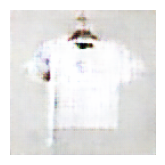

Epoch [  111/  500] | d_loss: 0.4341 | g_loss: 3.0429
Epoch [  112/  500] | d_loss: 0.5569 | g_loss: 3.7203
Epoch [  113/  500] | d_loss: 1.2780 | g_loss: 1.4152
Epoch [  114/  500] | d_loss: 0.5517 | g_loss: 2.4764
Epoch [  115/  500] | d_loss: 0.5177 | g_loss: 2.4575
Epoch [  116/  500] | d_loss: 0.4196 | g_loss: 3.9019
Epoch [  117/  500] | d_loss: 0.4546 | g_loss: 2.4008
Epoch [  118/  500] | d_loss: 1.2495 | g_loss: 5.7239
Epoch [  119/  500] | d_loss: 0.5269 | g_loss: 1.9943
Epoch [  120/  500] | d_loss: 0.4746 | g_loss: 2.6247


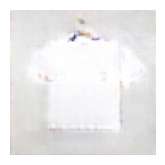

Epoch [  121/  500] | d_loss: 0.7311 | g_loss: 1.2429
Epoch [  122/  500] | d_loss: 0.9217 | g_loss: 2.9525
Epoch [  123/  500] | d_loss: 0.4585 | g_loss: 3.3376
Epoch [  124/  500] | d_loss: 0.4977 | g_loss: 2.8543
Epoch [  125/  500] | d_loss: 0.8636 | g_loss: 1.9011
Epoch [  126/  500] | d_loss: 0.5392 | g_loss: 2.1909
Epoch [  127/  500] | d_loss: 0.4053 | g_loss: 2.9258
Epoch [  128/  500] | d_loss: 0.5329 | g_loss: 3.3543
Epoch [  129/  500] | d_loss: 0.4026 | g_loss: 3.9838
Epoch [  130/  500] | d_loss: 0.8077 | g_loss: 1.8086


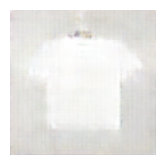

Epoch [  131/  500] | d_loss: 0.6692 | g_loss: 4.2663
Epoch [  132/  500] | d_loss: 0.3956 | g_loss: 3.9725
Epoch [  133/  500] | d_loss: 0.6630 | g_loss: 1.5519
Epoch [  134/  500] | d_loss: 0.4382 | g_loss: 3.1086
Epoch [  135/  500] | d_loss: 0.4140 | g_loss: 3.3339
Epoch [  136/  500] | d_loss: 0.4469 | g_loss: 3.5183
Epoch [  137/  500] | d_loss: 0.6233 | g_loss: 3.1099
Epoch [  138/  500] | d_loss: 0.4034 | g_loss: 3.1539
Epoch [  139/  500] | d_loss: 1.1591 | g_loss: 3.4579
Epoch [  140/  500] | d_loss: 1.0787 | g_loss: 1.6859


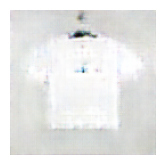

Epoch [  141/  500] | d_loss: 0.4197 | g_loss: 3.0007
Epoch [  142/  500] | d_loss: 0.4806 | g_loss: 3.8564
Epoch [  143/  500] | d_loss: 0.4341 | g_loss: 2.9014
Epoch [  144/  500] | d_loss: 0.4357 | g_loss: 2.8966
Epoch [  145/  500] | d_loss: 0.4146 | g_loss: 2.9102
Epoch [  146/  500] | d_loss: 0.3754 | g_loss: 3.4569
Epoch [  147/  500] | d_loss: 0.6482 | g_loss: 1.5535
Epoch [  148/  500] | d_loss: 0.4404 | g_loss: 2.7112
Epoch [  149/  500] | d_loss: 0.5315 | g_loss: 2.9769
Epoch [  150/  500] | d_loss: 0.5677 | g_loss: 1.7287


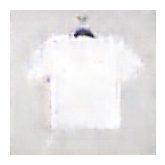

Epoch [  151/  500] | d_loss: 0.7575 | g_loss: 2.2366
Epoch [  152/  500] | d_loss: 0.5680 | g_loss: 4.4041
Epoch [  153/  500] | d_loss: 0.3782 | g_loss: 2.9785
Epoch [  154/  500] | d_loss: 0.4372 | g_loss: 2.9941
Epoch [  155/  500] | d_loss: 0.4672 | g_loss: 3.4147
Epoch [  156/  500] | d_loss: 0.8215 | g_loss: 1.8104
Epoch [  157/  500] | d_loss: 0.4360 | g_loss: 2.6421
Epoch [  158/  500] | d_loss: 0.4858 | g_loss: 2.8860
Epoch [  159/  500] | d_loss: 0.4425 | g_loss: 2.9531
Epoch [  160/  500] | d_loss: 0.5036 | g_loss: 3.3445


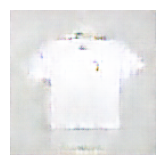

Epoch [  161/  500] | d_loss: 1.8135 | g_loss: 0.4248
Epoch [  162/  500] | d_loss: 0.5026 | g_loss: 2.8898
Epoch [  163/  500] | d_loss: 0.4478 | g_loss: 2.1014
Epoch [  164/  500] | d_loss: 0.6133 | g_loss: 3.1998
Epoch [  165/  500] | d_loss: 0.3965 | g_loss: 3.1185
Epoch [  166/  500] | d_loss: 0.3915 | g_loss: 3.1960
Epoch [  167/  500] | d_loss: 0.5310 | g_loss: 3.0218
Epoch [  168/  500] | d_loss: 0.4241 | g_loss: 3.6891
Epoch [  169/  500] | d_loss: 0.3888 | g_loss: 4.0474
Epoch [  170/  500] | d_loss: 0.4357 | g_loss: 3.2063


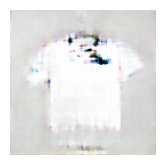

Epoch [  171/  500] | d_loss: 0.4174 | g_loss: 3.2445
Epoch [  172/  500] | d_loss: 0.7770 | g_loss: 2.4625
Epoch [  173/  500] | d_loss: 0.4814 | g_loss: 2.7970
Epoch [  174/  500] | d_loss: 0.4245 | g_loss: 2.8980
Epoch [  175/  500] | d_loss: 0.4649 | g_loss: 3.4271
Epoch [  176/  500] | d_loss: 0.4647 | g_loss: 2.9653
Epoch [  177/  500] | d_loss: 0.3835 | g_loss: 3.5413
Epoch [  178/  500] | d_loss: 0.4062 | g_loss: 2.1736
Epoch [  179/  500] | d_loss: 0.3715 | g_loss: 4.1898
Epoch [  180/  500] | d_loss: 0.3655 | g_loss: 4.6435


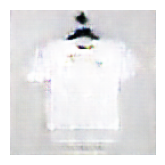

Epoch [  181/  500] | d_loss: 1.0041 | g_loss: 2.2239
Epoch [  182/  500] | d_loss: 0.5162 | g_loss: 2.2912
Epoch [  183/  500] | d_loss: 0.7427 | g_loss: 1.4473
Epoch [  184/  500] | d_loss: 0.3888 | g_loss: 2.6078
Epoch [  185/  500] | d_loss: 0.6411 | g_loss: 2.0873
Epoch [  186/  500] | d_loss: 0.5648 | g_loss: 4.2391
Epoch [  187/  500] | d_loss: 0.3798 | g_loss: 5.3334
Epoch [  188/  500] | d_loss: 0.4052 | g_loss: 3.7363
Epoch [  189/  500] | d_loss: 0.4102 | g_loss: 4.0122
Epoch [  190/  500] | d_loss: 0.5473 | g_loss: 2.9411


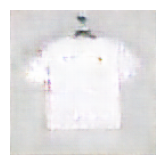

Epoch [  191/  500] | d_loss: 0.3789 | g_loss: 3.9243
Epoch [  192/  500] | d_loss: 0.3799 | g_loss: 4.5535
Epoch [  193/  500] | d_loss: 0.3726 | g_loss: 4.2010
Epoch [  194/  500] | d_loss: 0.4092 | g_loss: 2.4347
Epoch [  195/  500] | d_loss: 0.3678 | g_loss: 4.6421
Epoch [  196/  500] | d_loss: 0.4479 | g_loss: 3.8212
Epoch [  197/  500] | d_loss: 0.4291 | g_loss: 3.3515
Epoch [  198/  500] | d_loss: 0.5187 | g_loss: 2.1593
Epoch [  199/  500] | d_loss: 0.4245 | g_loss: 4.0349
Epoch [  200/  500] | d_loss: 0.6002 | g_loss: 3.4145


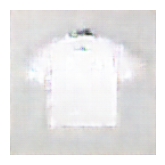

Epoch [  201/  500] | d_loss: 0.3948 | g_loss: 3.5690
Epoch [  202/  500] | d_loss: 0.4426 | g_loss: 3.1097
Epoch [  203/  500] | d_loss: 1.6461 | g_loss: 0.8328
Epoch [  204/  500] | d_loss: 0.5545 | g_loss: 3.1567
Epoch [  205/  500] | d_loss: 0.4872 | g_loss: 2.5323
Epoch [  206/  500] | d_loss: 0.4341 | g_loss: 3.3110
Epoch [  207/  500] | d_loss: 0.4796 | g_loss: 3.7578
Epoch [  208/  500] | d_loss: 0.4012 | g_loss: 2.8582
Epoch [  209/  500] | d_loss: 0.4041 | g_loss: 3.1115
Epoch [  210/  500] | d_loss: 0.4958 | g_loss: 2.6370


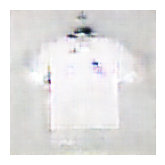

Epoch [  211/  500] | d_loss: 0.3605 | g_loss: 4.9655
Epoch [  212/  500] | d_loss: 0.4237 | g_loss: 4.1561
Epoch [  213/  500] | d_loss: 0.4211 | g_loss: 4.1334
Epoch [  214/  500] | d_loss: 0.4073 | g_loss: 3.9920
Epoch [  215/  500] | d_loss: 0.4025 | g_loss: 3.8032
Epoch [  216/  500] | d_loss: 0.3845 | g_loss: 4.6774
Epoch [  217/  500] | d_loss: 0.3906 | g_loss: 3.2253
Epoch [  218/  500] | d_loss: 0.7369 | g_loss: 3.6547
Epoch [  219/  500] | d_loss: 0.5079 | g_loss: 3.3081
Epoch [  220/  500] | d_loss: 0.3839 | g_loss: 3.4685


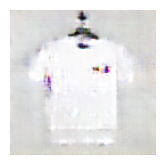

Epoch [  221/  500] | d_loss: 0.4251 | g_loss: 3.2805
Epoch [  222/  500] | d_loss: 0.3686 | g_loss: 4.1117
Epoch [  223/  500] | d_loss: 0.3891 | g_loss: 3.5950
Epoch [  224/  500] | d_loss: 0.4122 | g_loss: 4.0871
Epoch [  225/  500] | d_loss: 1.3333 | g_loss: 4.8021
Epoch [  226/  500] | d_loss: 0.4794 | g_loss: 3.0389
Epoch [  227/  500] | d_loss: 0.3872 | g_loss: 3.8219
Epoch [  228/  500] | d_loss: 0.3604 | g_loss: 4.0052
Epoch [  229/  500] | d_loss: 0.3672 | g_loss: 4.0700
Epoch [  230/  500] | d_loss: 0.3854 | g_loss: 4.2853


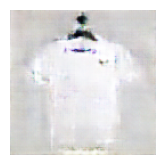

Epoch [  231/  500] | d_loss: 0.5185 | g_loss: 4.6816
Epoch [  232/  500] | d_loss: 0.9623 | g_loss: 4.3740
Epoch [  233/  500] | d_loss: 0.3753 | g_loss: 3.7478
Epoch [  234/  500] | d_loss: 0.3911 | g_loss: 4.3697
Epoch [  235/  500] | d_loss: 0.3811 | g_loss: 3.0059
Epoch [  236/  500] | d_loss: 0.4135 | g_loss: 4.5829
Epoch [  237/  500] | d_loss: 0.4467 | g_loss: 4.3360
Epoch [  238/  500] | d_loss: 0.3895 | g_loss: 4.6297
Epoch [  239/  500] | d_loss: 0.3806 | g_loss: 4.6357
Epoch [  240/  500] | d_loss: 0.3778 | g_loss: 3.5420


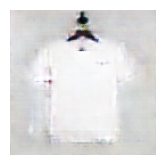

Epoch [  241/  500] | d_loss: 0.4249 | g_loss: 3.0856
Epoch [  242/  500] | d_loss: 0.6133 | g_loss: 2.3812
Epoch [  243/  500] | d_loss: 0.4004 | g_loss: 4.4547
Epoch [  244/  500] | d_loss: 0.3840 | g_loss: 3.0459
Epoch [  245/  500] | d_loss: 0.3690 | g_loss: 5.1413
Epoch [  246/  500] | d_loss: 0.7117 | g_loss: 5.0403
Epoch [  247/  500] | d_loss: 0.3484 | g_loss: 4.6797
Epoch [  248/  500] | d_loss: 0.3621 | g_loss: 3.9604
Epoch [  249/  500] | d_loss: 0.4367 | g_loss: 3.7720
Epoch [  250/  500] | d_loss: 0.3613 | g_loss: 4.8789


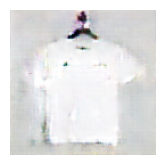

Epoch [  251/  500] | d_loss: 0.3680 | g_loss: 3.6591
Epoch [  252/  500] | d_loss: 0.5058 | g_loss: 2.7816
Epoch [  253/  500] | d_loss: 0.8980 | g_loss: 0.9194
Epoch [  254/  500] | d_loss: 0.4124 | g_loss: 3.4322
Epoch [  255/  500] | d_loss: 0.4160 | g_loss: 3.0003
Epoch [  256/  500] | d_loss: 0.6440 | g_loss: 2.2068
Epoch [  257/  500] | d_loss: 0.4112 | g_loss: 4.3410
Epoch [  258/  500] | d_loss: 1.0255 | g_loss: 3.2007
Epoch [  259/  500] | d_loss: 0.6137 | g_loss: 2.5269
Epoch [  260/  500] | d_loss: 0.3976 | g_loss: 4.1954


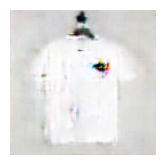

Epoch [  261/  500] | d_loss: 0.4226 | g_loss: 4.5684
Epoch [  262/  500] | d_loss: 0.3969 | g_loss: 4.2984
Epoch [  263/  500] | d_loss: 0.3695 | g_loss: 3.5687
Epoch [  264/  500] | d_loss: 0.3941 | g_loss: 4.3107
Epoch [  265/  500] | d_loss: 0.4511 | g_loss: 3.5022
Epoch [  266/  500] | d_loss: 0.3657 | g_loss: 4.3599
Epoch [  267/  500] | d_loss: 0.4798 | g_loss: 3.4343
Epoch [  268/  500] | d_loss: 0.4656 | g_loss: 3.0102
Epoch [  269/  500] | d_loss: 0.4161 | g_loss: 4.1369
Epoch [  270/  500] | d_loss: 0.5840 | g_loss: 2.0002


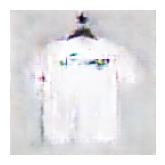

Epoch [  271/  500] | d_loss: 0.4232 | g_loss: 3.5556
Epoch [  272/  500] | d_loss: 0.3788 | g_loss: 3.6159
Epoch [  273/  500] | d_loss: 0.3710 | g_loss: 3.6997
Epoch [  274/  500] | d_loss: 0.3656 | g_loss: 3.7484
Epoch [  275/  500] | d_loss: 0.3582 | g_loss: 3.9149
Epoch [  276/  500] | d_loss: 0.4100 | g_loss: 3.8193
Epoch [  277/  500] | d_loss: 0.3586 | g_loss: 4.6956
Epoch [  278/  500] | d_loss: 0.4165 | g_loss: 4.3827
Epoch [  279/  500] | d_loss: 0.3842 | g_loss: 4.3995
Epoch [  280/  500] | d_loss: 0.3893 | g_loss: 3.6799


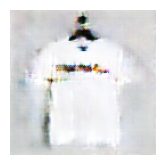

Epoch [  281/  500] | d_loss: 0.3686 | g_loss: 3.9182
Epoch [  282/  500] | d_loss: 0.3810 | g_loss: 3.6632
Epoch [  283/  500] | d_loss: 0.3859 | g_loss: 3.4599
Epoch [  284/  500] | d_loss: 0.5077 | g_loss: 2.5576
Epoch [  285/  500] | d_loss: 0.4256 | g_loss: 3.9097
Epoch [  286/  500] | d_loss: 0.4302 | g_loss: 3.3497
Epoch [  287/  500] | d_loss: 0.3956 | g_loss: 3.1881
Epoch [  288/  500] | d_loss: 0.3730 | g_loss: 4.1506
Epoch [  289/  500] | d_loss: 0.3997 | g_loss: 3.2923
Epoch [  290/  500] | d_loss: 0.6758 | g_loss: 4.7130


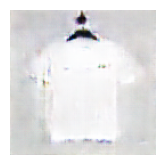

Epoch [  291/  500] | d_loss: 0.5369 | g_loss: 2.7485
Epoch [  292/  500] | d_loss: 0.3610 | g_loss: 4.3239
Epoch [  293/  500] | d_loss: 0.3678 | g_loss: 4.5358
Epoch [  294/  500] | d_loss: 0.5188 | g_loss: 3.8849
Epoch [  295/  500] | d_loss: 0.3735 | g_loss: 4.8955
Epoch [  296/  500] | d_loss: 0.4035 | g_loss: 3.7330
Epoch [  297/  500] | d_loss: 0.4168 | g_loss: 3.3015
Epoch [  298/  500] | d_loss: 0.7532 | g_loss: 4.4671
Epoch [  299/  500] | d_loss: 0.5377 | g_loss: 2.1958
Epoch [  300/  500] | d_loss: 0.5084 | g_loss: 3.2365


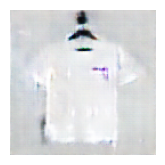

Epoch [  301/  500] | d_loss: 0.5632 | g_loss: 5.4561
Epoch [  302/  500] | d_loss: 0.4034 | g_loss: 3.3728
Epoch [  303/  500] | d_loss: 0.3926 | g_loss: 3.7704
Epoch [  304/  500] | d_loss: 0.4862 | g_loss: 3.0729
Epoch [  305/  500] | d_loss: 0.3800 | g_loss: 3.7418
Epoch [  306/  500] | d_loss: 0.4041 | g_loss: 4.0481
Epoch [  307/  500] | d_loss: 0.3715 | g_loss: 3.7178
Epoch [  308/  500] | d_loss: 0.3601 | g_loss: 4.3188
Epoch [  309/  500] | d_loss: 0.4130 | g_loss: 2.9119
Epoch [  310/  500] | d_loss: 0.4447 | g_loss: 2.7288


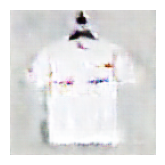

Epoch [  311/  500] | d_loss: 0.5047 | g_loss: 4.3969
Epoch [  312/  500] | d_loss: 0.6138 | g_loss: 4.6008
Epoch [  313/  500] | d_loss: 5.7002 | g_loss: 0.9190
Epoch [  314/  500] | d_loss: 0.6614 | g_loss: 3.1661
Epoch [  315/  500] | d_loss: 0.4272 | g_loss: 3.1519
Epoch [  316/  500] | d_loss: 0.3798 | g_loss: 3.5533
Epoch [  317/  500] | d_loss: 0.3643 | g_loss: 3.7779
Epoch [  318/  500] | d_loss: 0.6262 | g_loss: 3.0286
Epoch [  319/  500] | d_loss: 0.4750 | g_loss: 2.2656
Epoch [  320/  500] | d_loss: 0.4026 | g_loss: 4.1244


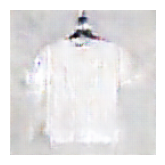

Epoch [  321/  500] | d_loss: 0.4245 | g_loss: 3.3095
Epoch [  322/  500] | d_loss: 0.4532 | g_loss: 4.0406
Epoch [  323/  500] | d_loss: 0.5037 | g_loss: 3.0260
Epoch [  324/  500] | d_loss: 0.3741 | g_loss: 3.4370
Epoch [  325/  500] | d_loss: 0.4176 | g_loss: 3.2310
Epoch [  326/  500] | d_loss: 0.3766 | g_loss: 4.5980
Epoch [  327/  500] | d_loss: 0.3539 | g_loss: 5.0183
Epoch [  328/  500] | d_loss: 0.3676 | g_loss: 3.6780
Epoch [  329/  500] | d_loss: 0.3783 | g_loss: 3.9684
Epoch [  330/  500] | d_loss: 0.3762 | g_loss: 3.8597


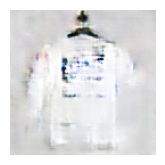

Epoch [  331/  500] | d_loss: 0.4331 | g_loss: 3.0674
Epoch [  332/  500] | d_loss: 0.3898 | g_loss: 4.1953
Epoch [  333/  500] | d_loss: 0.3600 | g_loss: 3.9454
Epoch [  334/  500] | d_loss: 0.3919 | g_loss: 3.7581
Epoch [  335/  500] | d_loss: 0.3828 | g_loss: 4.1950
Epoch [  336/  500] | d_loss: 0.3790 | g_loss: 4.1540
Epoch [  337/  500] | d_loss: 0.4979 | g_loss: 4.2548
Epoch [  338/  500] | d_loss: 0.4131 | g_loss: 3.9230
Epoch [  339/  500] | d_loss: 0.3621 | g_loss: 4.0290
Epoch [  340/  500] | d_loss: 0.4062 | g_loss: 4.6231


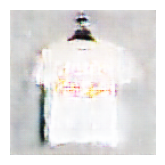

Epoch [  341/  500] | d_loss: 0.3946 | g_loss: 4.1877
Epoch [  342/  500] | d_loss: 0.4403 | g_loss: 2.9956
Epoch [  343/  500] | d_loss: 0.4401 | g_loss: 3.9554
Epoch [  344/  500] | d_loss: 0.3583 | g_loss: 5.4758
Epoch [  345/  500] | d_loss: 0.3902 | g_loss: 4.7205
Epoch [  346/  500] | d_loss: 0.3630 | g_loss: 3.9028
Epoch [  347/  500] | d_loss: 0.4301 | g_loss: 4.1397
Epoch [  348/  500] | d_loss: 0.5366 | g_loss: 3.0751
Epoch [  349/  500] | d_loss: 0.5076 | g_loss: 3.6418
Epoch [  350/  500] | d_loss: 0.4487 | g_loss: 3.4115


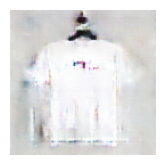

Epoch [  351/  500] | d_loss: 0.3962 | g_loss: 5.7387
Epoch [  352/  500] | d_loss: 0.3852 | g_loss: 4.4214
Epoch [  353/  500] | d_loss: 0.3448 | g_loss: 5.0885
Epoch [  354/  500] | d_loss: 9.7688 | g_loss: 1.1782
Epoch [  355/  500] | d_loss: 1.0340 | g_loss: 4.6895
Epoch [  356/  500] | d_loss: 0.4774 | g_loss: 2.7743
Epoch [  357/  500] | d_loss: 0.3793 | g_loss: 4.3644
Epoch [  358/  500] | d_loss: 0.4480 | g_loss: 4.1729
Epoch [  359/  500] | d_loss: 0.4568 | g_loss: 3.6462
Epoch [  360/  500] | d_loss: 0.3883 | g_loss: 5.7762


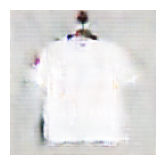

Epoch [  361/  500] | d_loss: 0.3999 | g_loss: 3.8592
Epoch [  362/  500] | d_loss: 0.3937 | g_loss: 4.2631
Epoch [  363/  500] | d_loss: 0.4832 | g_loss: 3.7217
Epoch [  364/  500] | d_loss: 0.3740 | g_loss: 4.0140
Epoch [  365/  500] | d_loss: 0.3653 | g_loss: 5.0995
Epoch [  366/  500] | d_loss: 0.3947 | g_loss: 3.6444
Epoch [  367/  500] | d_loss: 1.8203 | g_loss: 7.7719
Epoch [  368/  500] | d_loss: 0.4605 | g_loss: 3.7001
Epoch [  369/  500] | d_loss: 0.4420 | g_loss: 2.5694
Epoch [  370/  500] | d_loss: 0.3717 | g_loss: 4.2297


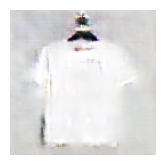

Epoch [  371/  500] | d_loss: 0.3653 | g_loss: 3.9695
Epoch [  372/  500] | d_loss: 0.4031 | g_loss: 3.9570
Epoch [  373/  500] | d_loss: 0.3629 | g_loss: 4.0276
Epoch [  374/  500] | d_loss: 0.4627 | g_loss: 2.3970
Epoch [  375/  500] | d_loss: 0.3437 | g_loss: 5.0768
Epoch [  376/  500] | d_loss: 0.3636 | g_loss: 4.4945
Epoch [  377/  500] | d_loss: 0.5701 | g_loss: 3.2397
Epoch [  378/  500] | d_loss: 0.3689 | g_loss: 3.8359
Epoch [  379/  500] | d_loss: 0.4128 | g_loss: 4.0218
Epoch [  380/  500] | d_loss: 0.4443 | g_loss: 3.7854


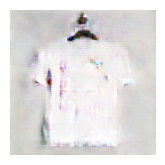

Epoch [  381/  500] | d_loss: 0.3817 | g_loss: 5.3828
Epoch [  382/  500] | d_loss: 0.3896 | g_loss: 4.1035
Epoch [  383/  500] | d_loss: 0.3793 | g_loss: 3.5368
Epoch [  384/  500] | d_loss: 0.3808 | g_loss: 3.9482
Epoch [  385/  500] | d_loss: 0.3991 | g_loss: 4.7203
Epoch [  386/  500] | d_loss: 0.3989 | g_loss: 4.7257
Epoch [  387/  500] | d_loss: 0.3556 | g_loss: 4.7876
Epoch [  388/  500] | d_loss: 0.3663 | g_loss: 5.6207
Epoch [  389/  500] | d_loss: 0.3775 | g_loss: 4.3247
Epoch [  390/  500] | d_loss: 0.3734 | g_loss: 3.5348


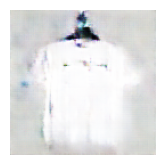

Epoch [  391/  500] | d_loss: 0.3842 | g_loss: 4.2988
Epoch [  392/  500] | d_loss: 0.3834 | g_loss: 4.3779
Epoch [  393/  500] | d_loss: 0.4066 | g_loss: 3.4574
Epoch [  394/  500] | d_loss: 0.3683 | g_loss: 3.6097
Epoch [  395/  500] | d_loss: 0.3540 | g_loss: 5.6581
Epoch [  396/  500] | d_loss: 0.3623 | g_loss: 4.3979
Epoch [  397/  500] | d_loss: 0.3530 | g_loss: 4.2525
Epoch [  398/  500] | d_loss: 0.4140 | g_loss: 5.4822
Epoch [  399/  500] | d_loss: 1.2370 | g_loss: 1.0724
Epoch [  400/  500] | d_loss: 0.4404 | g_loss: 3.7951


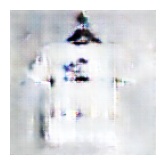

Epoch [  401/  500] | d_loss: 0.5015 | g_loss: 3.2255
Epoch [  402/  500] | d_loss: 0.3723 | g_loss: 5.0961
Epoch [  403/  500] | d_loss: 0.3623 | g_loss: 4.8096
Epoch [  404/  500] | d_loss: 0.3706 | g_loss: 5.3829
Epoch [  405/  500] | d_loss: 0.3820 | g_loss: 3.9859
Epoch [  406/  500] | d_loss: 0.3535 | g_loss: 4.3237
Epoch [  407/  500] | d_loss: 0.3661 | g_loss: 5.3063
Epoch [  408/  500] | d_loss: 0.3729 | g_loss: 4.8537
Epoch [  409/  500] | d_loss: 0.4290 | g_loss: 3.0995
Epoch [  410/  500] | d_loss: 0.3734 | g_loss: 5.0214


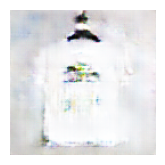

Epoch [  411/  500] | d_loss: 0.4045 | g_loss: 3.8667
Epoch [  412/  500] | d_loss: 0.3908 | g_loss: 4.4993
Epoch [  413/  500] | d_loss: 0.3870 | g_loss: 3.4499
Epoch [  414/  500] | d_loss: 0.3498 | g_loss: 5.4008
Epoch [  415/  500] | d_loss: 0.3943 | g_loss: 4.2347
Epoch [  416/  500] | d_loss: 0.4164 | g_loss: 3.3899
Epoch [  417/  500] | d_loss: 0.4643 | g_loss: 4.3856
Epoch [  418/  500] | d_loss: 0.3956 | g_loss: 3.7305
Epoch [  419/  500] | d_loss: 0.4049 | g_loss: 3.4165
Epoch [  420/  500] | d_loss: 0.3642 | g_loss: 5.3484


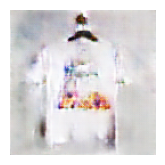

Epoch [  421/  500] | d_loss: 0.3617 | g_loss: 4.5926
Epoch [  422/  500] | d_loss: 0.3802 | g_loss: 4.8063
Epoch [  423/  500] | d_loss: 0.3721 | g_loss: 5.3780
Epoch [  424/  500] | d_loss: 0.4245 | g_loss: 5.2332
Epoch [  425/  500] | d_loss: 0.3701 | g_loss: 4.7095
Epoch [  426/  500] | d_loss: 0.3602 | g_loss: 4.1317
Epoch [  427/  500] | d_loss: 0.3516 | g_loss: 5.1783
Epoch [  428/  500] | d_loss: 0.3669 | g_loss: 3.9274
Epoch [  429/  500] | d_loss: 0.5079 | g_loss: 4.3678
Epoch [  430/  500] | d_loss: 0.3740 | g_loss: 4.1963


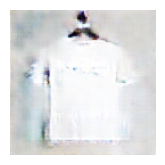

Epoch [  431/  500] | d_loss: 0.3691 | g_loss: 4.7384
Epoch [  432/  500] | d_loss: 0.3541 | g_loss: 4.9912
Epoch [  433/  500] | d_loss: 0.4612 | g_loss: 3.1602
Epoch [  434/  500] | d_loss: 0.3546 | g_loss: 4.0001
Epoch [  435/  500] | d_loss: 0.3557 | g_loss: 5.3445
Epoch [  436/  500] | d_loss: 0.4118 | g_loss: 4.8003
Epoch [  437/  500] | d_loss: 0.4412 | g_loss: 4.1194
Epoch [  438/  500] | d_loss: 0.3942 | g_loss: 4.7819
Epoch [  439/  500] | d_loss: 0.3851 | g_loss: 4.2389
Epoch [  440/  500] | d_loss: 0.3874 | g_loss: 3.7623


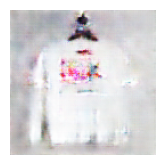

Epoch [  441/  500] | d_loss: 0.3808 | g_loss: 4.2285
Epoch [  442/  500] | d_loss: 0.3627 | g_loss: 4.7138
Epoch [  443/  500] | d_loss: 0.4460 | g_loss: 2.6793
Epoch [  444/  500] | d_loss: 0.3744 | g_loss: 3.9889
Epoch [  445/  500] | d_loss: 0.3804 | g_loss: 6.0960
Epoch [  446/  500] | d_loss: 0.3598 | g_loss: 4.4101
Epoch [  447/  500] | d_loss: 0.4130 | g_loss: 5.1665
Epoch [  448/  500] | d_loss: 0.3543 | g_loss: 4.3407
Epoch [  449/  500] | d_loss: 0.3755 | g_loss: 5.2270
Epoch [  450/  500] | d_loss: 0.3542 | g_loss: 4.7502


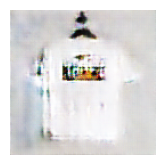

Epoch [  451/  500] | d_loss: 0.3663 | g_loss: 4.6892
Epoch [  452/  500] | d_loss: 0.3626 | g_loss: 8.1044
Epoch [  453/  500] | d_loss: 0.4315 | g_loss: 3.5996
Epoch [  454/  500] | d_loss: 0.4418 | g_loss: 5.9700
Epoch [  455/  500] | d_loss: 0.3975 | g_loss: 4.6926
Epoch [  456/  500] | d_loss: 0.3532 | g_loss: 3.9495
Epoch [  457/  500] | d_loss: 0.4076 | g_loss: 4.0061
Epoch [  458/  500] | d_loss: 0.3957 | g_loss: 4.1747
Epoch [  459/  500] | d_loss: 0.3819 | g_loss: 4.3164
Epoch [  460/  500] | d_loss: 0.3885 | g_loss: 4.8188


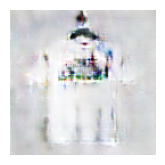

Epoch [  461/  500] | d_loss: 0.3565 | g_loss: 5.1959
Epoch [  462/  500] | d_loss: 0.3823 | g_loss: 5.4522
Epoch [  463/  500] | d_loss: 0.4212 | g_loss: 2.9170
Epoch [  464/  500] | d_loss: 0.3711 | g_loss: 4.9296
Epoch [  465/  500] | d_loss: 0.3657 | g_loss: 3.9197
Epoch [  466/  500] | d_loss: 0.6288 | g_loss: 4.8675
Epoch [  467/  500] | d_loss: 0.3751 | g_loss: 4.7473
Epoch [  468/  500] | d_loss: 0.3672 | g_loss: 5.6634
Epoch [  469/  500] | d_loss: 0.3904 | g_loss: 4.9229
Epoch [  470/  500] | d_loss: 0.4840 | g_loss: 4.5359


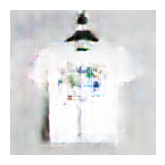

Epoch [  471/  500] | d_loss: 0.3610 | g_loss: 4.0086
Epoch [  472/  500] | d_loss: 0.3909 | g_loss: 3.5639
Epoch [  473/  500] | d_loss: 0.3712 | g_loss: 5.2209
Epoch [  474/  500] | d_loss: 0.3519 | g_loss: 4.6796
Epoch [  475/  500] | d_loss: 0.3956 | g_loss: 3.6074
Epoch [  476/  500] | d_loss: 0.3894 | g_loss: 3.9730
Epoch [  477/  500] | d_loss: 0.3546 | g_loss: 4.2287
Epoch [  478/  500] | d_loss: 0.4326 | g_loss: 3.4871
Epoch [  479/  500] | d_loss: 0.3746 | g_loss: 5.6495
Epoch [  480/  500] | d_loss: 0.4243 | g_loss: 4.2214


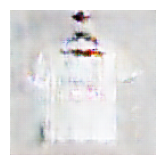

Epoch [  481/  500] | d_loss: 0.3586 | g_loss: 5.6582
Epoch [  482/  500] | d_loss: 0.4791 | g_loss: 4.5678
Epoch [  483/  500] | d_loss: 0.4154 | g_loss: 4.4816
Epoch [  484/  500] | d_loss: 0.3713 | g_loss: 4.6101
Epoch [  485/  500] | d_loss: 0.3645 | g_loss: 3.8011
Epoch [  486/  500] | d_loss: 0.3590 | g_loss: 4.9750
Epoch [  487/  500] | d_loss: 0.3725 | g_loss: 5.8897
Epoch [  488/  500] | d_loss: 0.3659 | g_loss: 4.8635
Epoch [  489/  500] | d_loss: 0.3505 | g_loss: 4.3998
Epoch [  490/  500] | d_loss: 1.6507 | g_loss: 8.8155


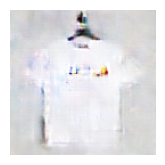

Epoch [  491/  500] | d_loss: 1.9019 | g_loss: 6.3635
Epoch [  492/  500] | d_loss: 0.5884 | g_loss: 2.6520
Epoch [  493/  500] | d_loss: 0.4362 | g_loss: 3.9277
Epoch [  494/  500] | d_loss: 0.4135 | g_loss: 3.8166
Epoch [  495/  500] | d_loss: 0.3815 | g_loss: 3.8067
Epoch [  496/  500] | d_loss: 0.4638 | g_loss: 4.9740
Epoch [  497/  500] | d_loss: 0.3803 | g_loss: 5.3727
Epoch [  498/  500] | d_loss: 0.3730 | g_loss: 3.4718
Epoch [  499/  500] | d_loss: 0.3625 | g_loss: 4.1066
Epoch [  500/  500] | d_loss: 0.4053 | g_loss: 4.5268


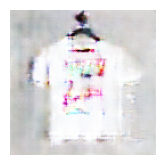

In [18]:
train(
    disc,gen,
    n_epochs,dataloader,
    d_optimizer,g_optimizer,
    z_dim,
    print_every=10,
    device=device,
)

In [19]:
def save_model(gen,file_name):
    gen = gen.to('cpu')
    torch.save(gen.state_dict(),"gen_128_epoch_350.pth")

save_model(gen,"kaggle")

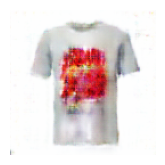

In [20]:
#sample generation
import cv2
import os
gen.to(device)
gen.eval()
sample_size=8
os.mkdir("/kaggle/working/generated_images")
for i in range(10):
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)    
    sample_image = gen(fixed_z)
    print_tensor_images(sample_image,True, f"/kaggle/working/generated_images/image{i}.jpg")

In [21]:
import cv2
import os
import torch
from torchvision import datasets
from torchvision import transforms
import os
from glob import glob
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv
device = 0

z_dim = 150
sample_size=8

class Generator(nn.Module):
    def __init__(self, z_dim=10, in_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim

        self.generator = nn.Sequential(
            self.make_gen_block(z_dim, 512, stride=1, padding=0),
            self.make_gen_block(512, 256),
            self.make_gen_block(256, 128),
            self.make_gen_block(128, 64),
            self.make_gen_block(64, 32),
            self.make_gen_block(32, in_chan, final_layer=True),
        )

    def make_gen_block(
        self, in_channels, op_channels, kernel_size=4, stride=2, padding=1, final_layer=False
    ):
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels, op_channels, kernel_size, stride, padding, bias=False))

        if not final_layer:
            layers.append(nn.BatchNorm2d(op_channels))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())

        return nn.Sequential(*layers)

    def forward(self, noise):
        x = noise.view(-1, self.z_dim, 1, 1)
        return self.generator(x)

    @staticmethod
    def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)

In [22]:
# # Assuming 'device' and 'sample_size' are defined before this point
# gen = Generator(z_dim=150)
# gen.load_state_dict(torch.load("/kaggle/input/my-model/gen_128_epoch_350.pth"))
gen.to(device)
gen.eval()

os.makedirs("/kaggle/working/generated_images", exist_ok=True)

for i in range(10):
    fixed_z = Generator.get_noise(n_samples=sample_size, z_dim=z_dim, device=device)
    images_tensor = gen(fixed_z)
    images_tensor = images_tensor.to('cpu').detach().numpy()
    images_tensor = (images_tensor * 0.5 + 0.5) * 255  # Adjust scaling for OpenCV
    images_tensor = images_tensor.astype(np.uint8)
    cv2.imwrite(f"/kaggle/working/generated_images/image{i}.jpg", images_tensor[0].transpose(1, 2, 0))

In [23]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
import torch
from PIL import Image
from RealESRGAN import RealESRGAN
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def apply_esrgan(image_path, model, iterations=10):
    image = Image.open(image_path).convert('RGB')
    for _ in tqdm(range(iterations)):
        sr_image = model.predict(image)
        image = sr_image
    return sr_image

model = RealESRGAN(device, scale=4)
model.load_weights('/kaggle/working/weights-model/RealESRGAN_x4.pth',download=True)
print("model Loaded")
for img in os.listdir("/kaggle/working/generated_images"):
    path_to_image = f'/kaggle/working/generated_images/{img}'
    enhanced_image = apply_esrgan(path_to_image, model, iterations=3)
    img = img.split(".")[0]
    if os.path.exists("/kaggle/working/enhanced_images"):
        enhanced_image.save(f'/kaggle/working/enhanced_images/{img}_enhanced_image.png')
    else:
        os.mkdir("/kaggle/working/enhanced_images")
        enhanced_image.save(f'/kaggle/working/enhanced_images/{img}_enhanced_image.png')

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-9tzaxdwz
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-9tzaxdwz
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... - done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9106 sha256=63e9128da41b469ea006d958683f5f77e118b75fcd965062bc16d9ad347603e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdo9jk1e/wheels/dd/a3/7d/774508ed192455403be294c8a6c4ad1c83dde8fcdd8903e64a
Successfully built RealESRGAN


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Weights downloaded to: /kaggle/working/weights-model/RealESRGAN_x4.pth
model Loaded


100%|██████████| 3/3 [00:37<00:00, 12.62s/it]


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/working/generated_images/image3.jpg
/kaggle/working/enhanced_images/image3_enhanced_image.png


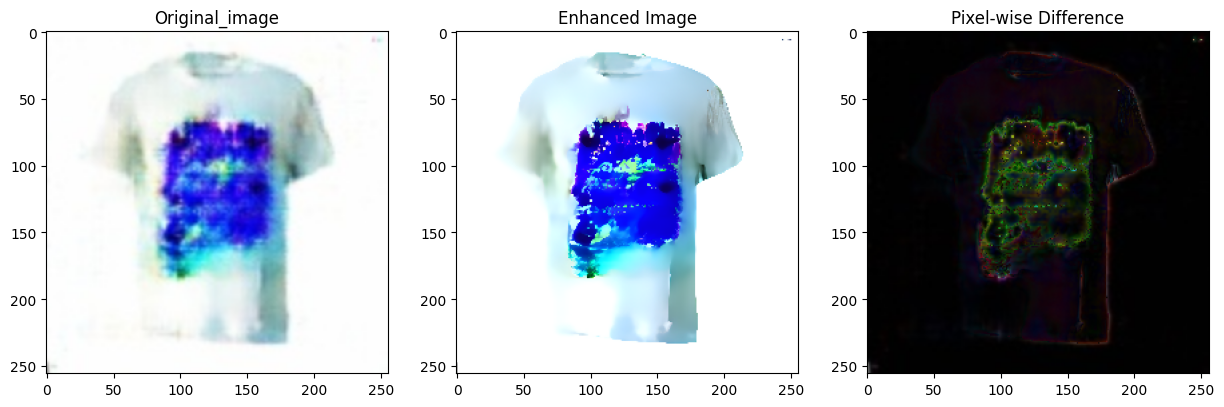

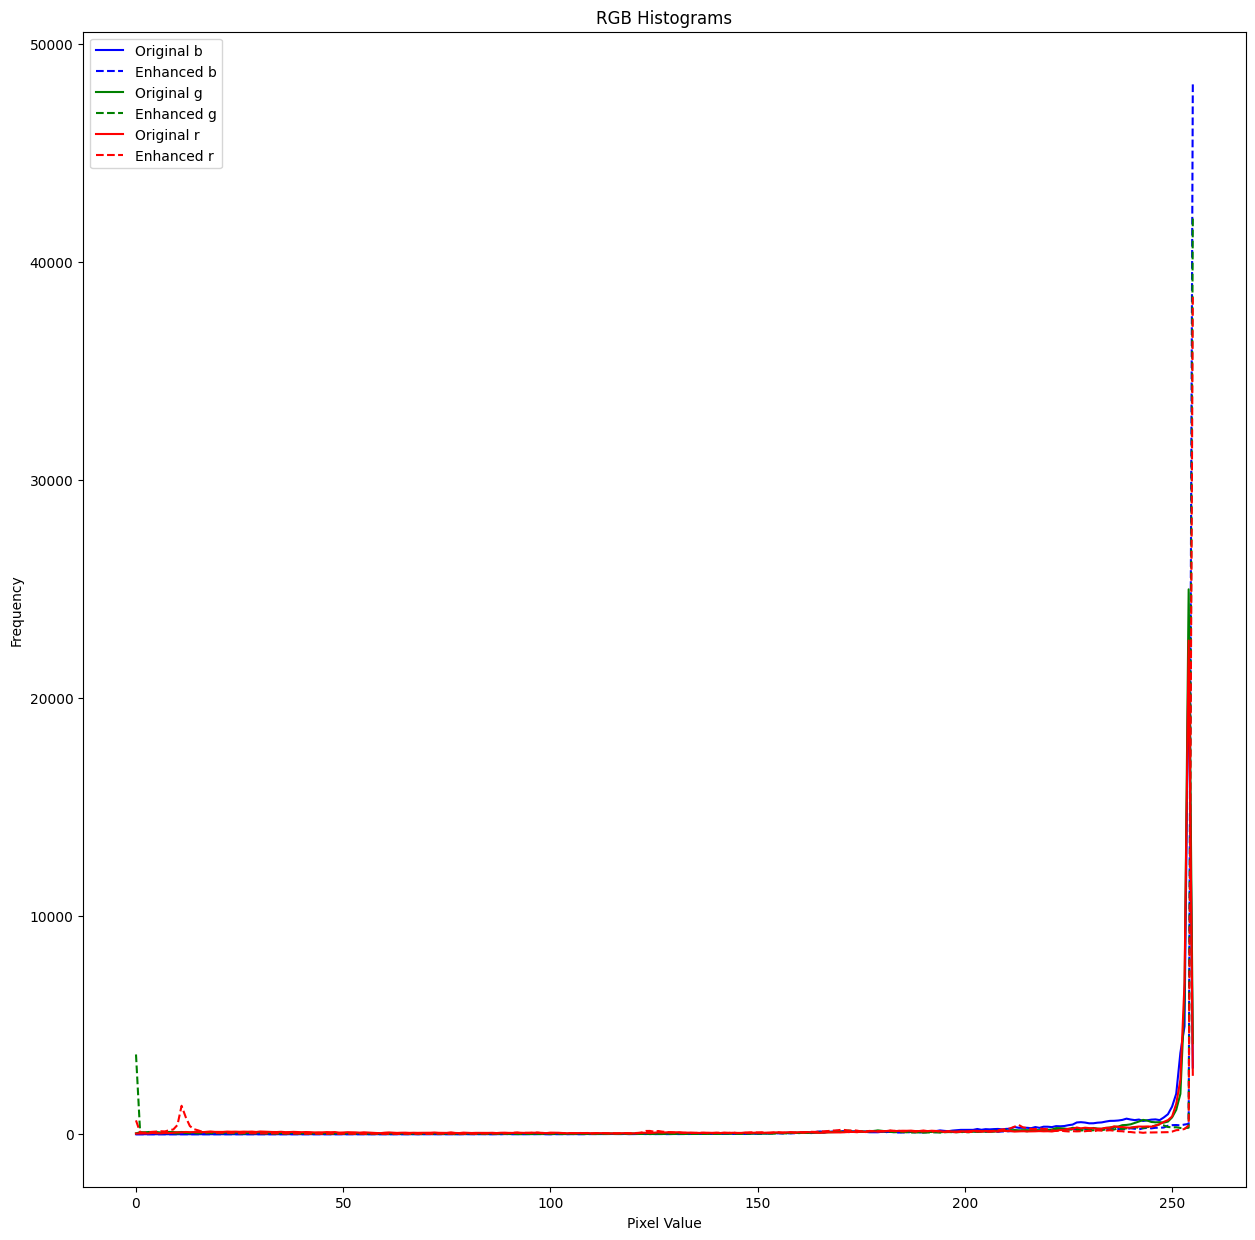

Structural Similarity Index (SSI): 0.9031
Mean Squared Error (MSE): 37.1537


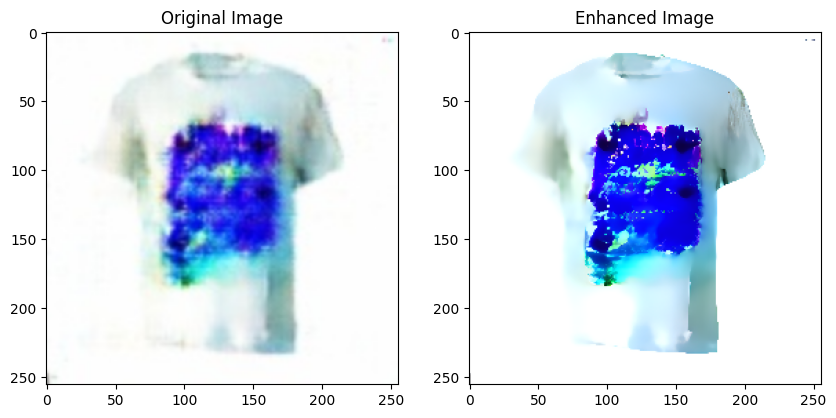

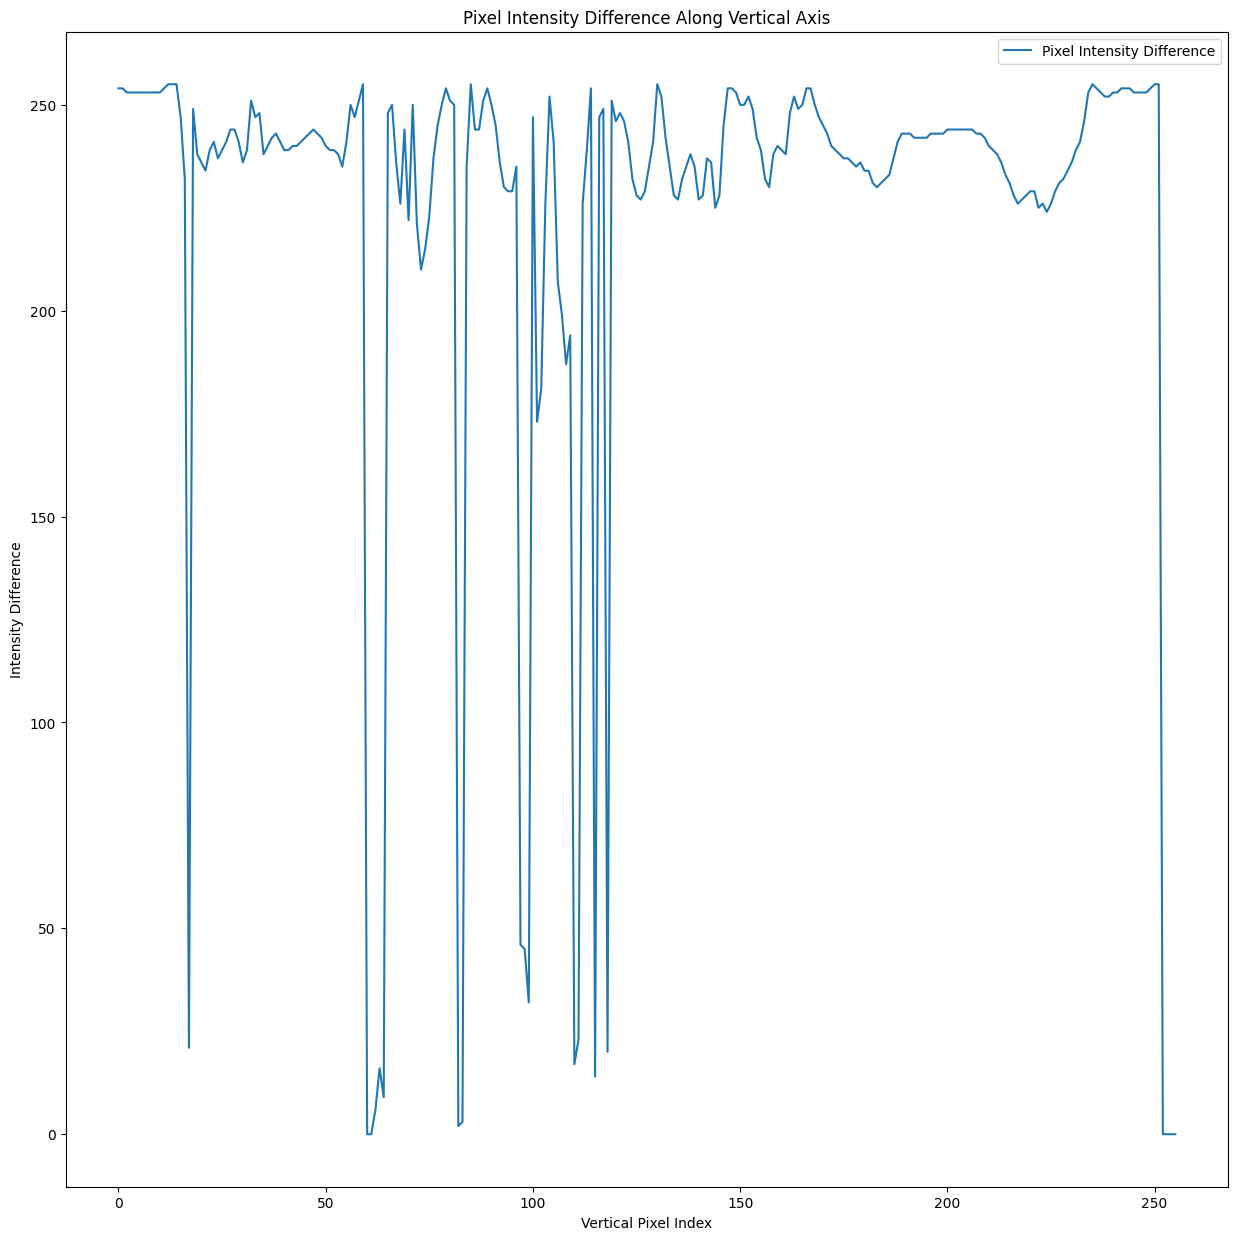

In [24]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/enhanced_images/image4_enhanced_image.png')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def load_random_image(directory, target_size=(256, 256), img_name=None):
    files = os.listdir(directory)
    if img_name is None:
        img_name = np.random.choice(files)
    else:
        img_name = img_name.split(".")[0] + "_enhanced_image.png"
    file_path = os.path.join(directory, img_name)
    print(file_path)
    image = cv2.imread(file_path)
    image = cv2.resize(image, target_size)
    return image, img_name

def visualize_difference(original_image, enhanced_image, orig_title="Original_image", enhance_title="Enhanced Image"):
    # Ensure images have the same dimensions
    height, width, _ = original_image.shape
    enhanced_image = cv2.resize(enhanced_image, (width, height))

    # Compute pixel-wise absolute difference
    diff = cv2.absdiff(original_image, enhanced_image)

    # Structural Similarity Index (SSI)
    ssi_index, _ = ssim(cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY),
                        cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2GRAY), full=True)

    # Mean Squared Error (MSE)
    mse = np.sum((original_image - enhanced_image) ** 2) / float(original_image.size)

    # Plot original, enhanced, and difference images side by side
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(orig_title)

    plt.subplot(132)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title(enhance_title)

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
    plt.title('Pixel-wise Difference')

    plt.show()

    # Plot RGB histograms for original and enhanced images
    colors = ('b', 'g', 'r')
    for i, col in enumerate(colors):
        hist_original = cv2.calcHist([original_image], [i], None, [256], [0, 256])
        hist_enhanced = cv2.calcHist([enhanced_image], [i], None, [256], [0, 256])

        plt.plot(hist_original, color=col, label=orig_title.split("_")[0] + " " + col)
        plt.plot(hist_enhanced, color=col, linestyle='dashed', label='Enhanced ' + col)

    plt.title('RGB Histograms')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Display SSIM Index and MSE
    print(f'Structural Similarity Index (SSI): {ssi_index:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')

    # Display side-by-side comparison
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(122)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title('Enhanced Image')

    plt.show()

    # Line plot showing pixel intensity differences along the vertical axis
    plt.plot(np.abs(original_image[:, width // 2, 0] - enhanced_image[:, width // 2, 0]), label='Pixel Intensity Difference')
    plt.title('Pixel Intensity Difference Along Vertical Axis')
    plt.xlabel('Vertical Pixel Index')
    plt.ylabel('Intensity Difference')
    plt.legend()
    plt.show()

# Paths to the directories containing generated and enhanced images
generated_images_dir = '/kaggle/working/generated_images'
enhanced_images_dir = '/kaggle/working/enhanced_images'

# Load random images from each directory
generated_image, img_path = load_random_image(generated_images_dir)
enhanced_image, _ = load_random_image(enhanced_images_dir, img_name=img_path)

# Visualize differences between the images
visualize_difference(generated_image, enhanced_image)

/kaggle/input/new-generated-and-collected-printed-t-shirts/tshirt/2421.jpg
/kaggle/working/enhanced_images/image4_enhanced_image.png


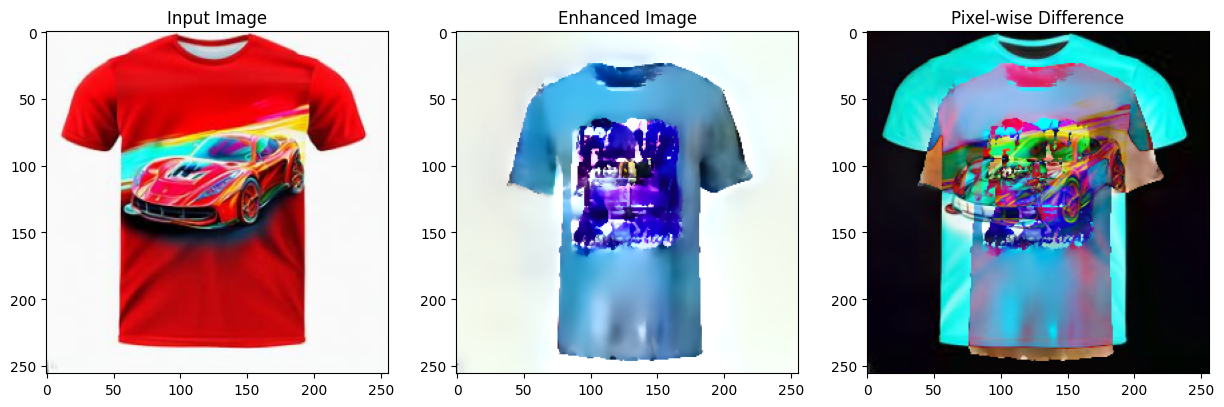

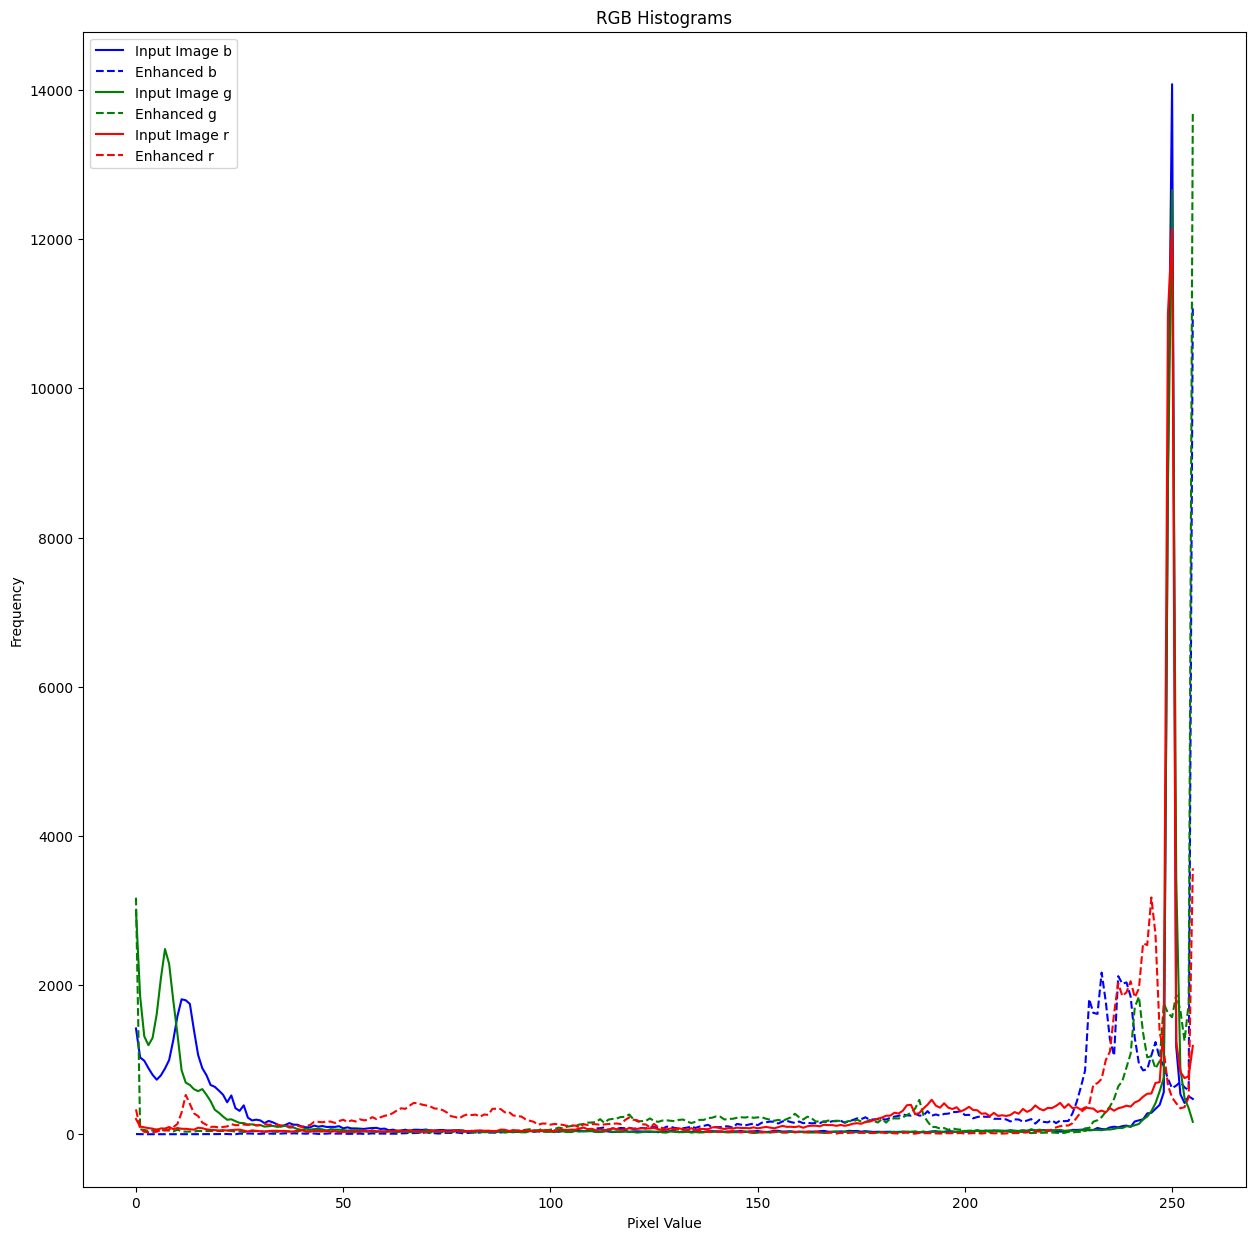

Structural Similarity Index (SSI): 0.4658
Mean Squared Error (MSE): 83.9975


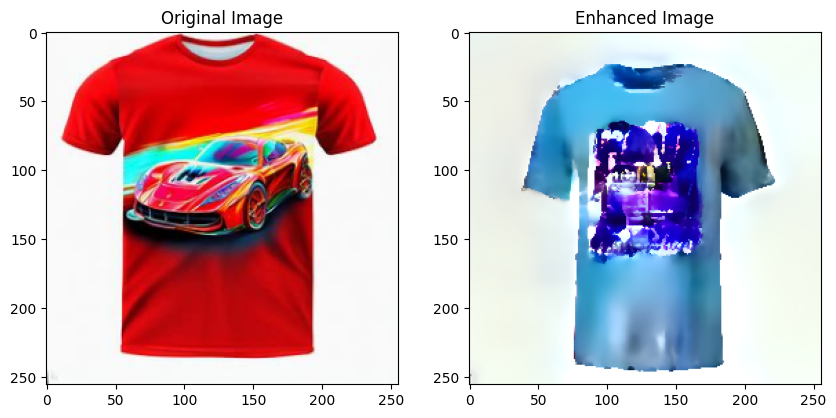

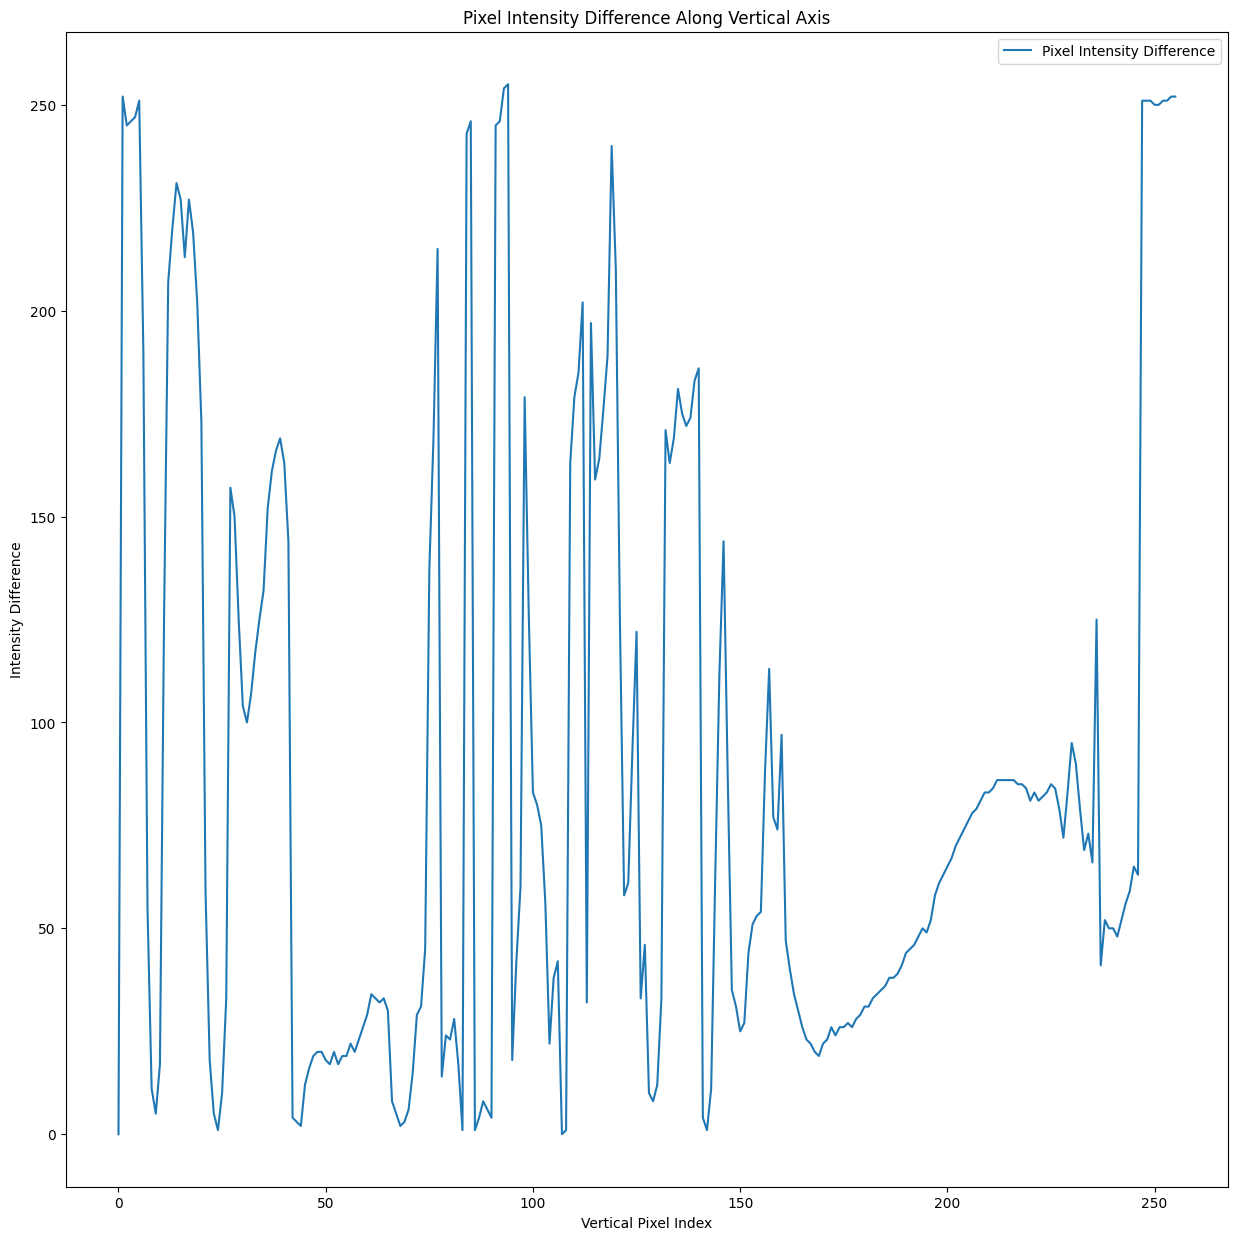

In [25]:
# Paths to the directories containing generated and enhanced images
input_images_dir = '/kaggle/input/new-generated-and-collected-printed-t-shirts/tshirt'
enhanced_images_dir = '/kaggle/working/enhanced_images'

input_image,_ = load_random_image(input_images_dir)
enhanced_image,_ = load_random_image(enhanced_images_dir)

# Visualize differences between the images
visualize_difference(input_image, enhanced_image,orig_title="Input Image")

In [26]:
import zipfile
import os

def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# Example usage
folder_to_zip = '/kaggle/working/enhanced_images'
zip_file_path = '/kaggle/working/enhanced_images_output.zip'

zip_folder(folder_to_zip, zip_file_path)


folder_to_zip = '/kaggle/working/generated_images'
zip_file_path = '/kaggle/working/generated_images_output.zip'

zip_folder(folder_to_zip, zip_file_path)